In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
import h5py
from halotools.empirical_models import Zheng07Cens, Zheng07Sats
from GNN.inputs import  split
from scipy.optimize import curve_fit
from sklearn.metrics import confusion_matrix
from GNN.utils.cm import plot_confusion_matrix

In [2]:
hdf5_filename = '/cosma5/data/dp004/dc-cues1/features/halo_features_s99'

with h5py.File(hdf5_filename,'r+') as feats: 
    
    mass = feats['M200c'][:]
    
    labels = feats['Ngals'][:]
    
    boxsize = feats['boxsize'].value / 1000. # to Mpc
    
    positions = feats['Pos'][:] / 1000.

    rvir = feats['R200c'][:] / 1000.


#labels = labels > 0 

In [3]:
train_idx, test_idx, val_idx = split.train_test_val_split(len(mass))

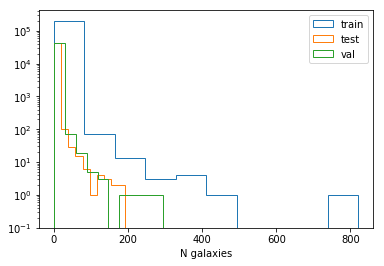

In [4]:
plt.hist(labels[train_idx], log=True, histtype='step', label = 'train')
plt.hist(labels[test_idx], log=True, histtype='step', label = 'test')
plt.hist(labels[val_idx], log=True, histtype='step', label = 'val')
plt.xlabel('N galaxies')
plt.legend()

Text(0.5,0,'$M_{200c}$')

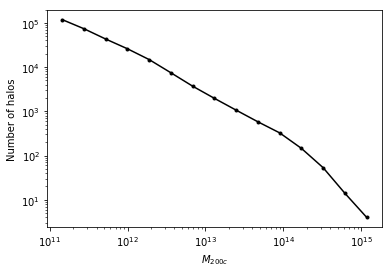

In [5]:
nbins= 15
bins = np.logspace(np.log10(np.min(mass)),
                   np.log10(np.max(mass)), nbins+1)

bin_centers = (bins[1:]+bins[:-1])/2.

mass_func, edges = np.histogram(mass, bins=bins)
plt.loglog((edges[1:]+edges[:-1])/2.,
           mass_func,color='black', marker='o',markersize=3)

plt.ylabel('Number of halos')
plt.xlabel(r'$M_{200c}$')

# Fit HOD parameters to training set

In [6]:
n_centrals = labels[train_idx] > 0
n_satellites = labels[train_idx] - 1

In [7]:
n_centrals_binned, edges, _ = binned_statistic(mass[train_idx], n_centrals, statistic = 'mean',
                                     bins=bins)

n_centrals_error, edges, _ = binned_statistic(mass[train_idx], n_centrals, statistic = 'std',
                                     bins=bins)

In [8]:
n_satellites_binned, edges, _ = binned_statistic(mass[train_idx], n_satellites, statistic = 'mean',
                                     bins=bins)

n_satellites_error, edges, _ = binned_statistic(mass[train_idx], n_satellites, statistic = 'std',
                                     bins=bins)

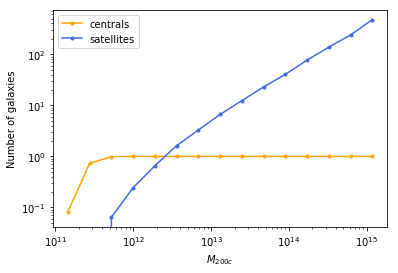

In [9]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

## Find HOD parameters

In [10]:
cen_model = Zheng07Cens()

def mean_centrals(mass, logMin, sigma_logM):

    cen_model.param_dict = {'logMmin': logMin,
                    'sigma_logM': sigma_logM}
    
    return cen_model.mean_occupation(prim_haloprop = mass)

sats_model = Zheng07Sats()

def mean_sats(mass, M0, M1, alpha):
    
    logM0 = np.log10(M0)

    logM1 = np.log10(M1)
    
    sats_model.param_dict = {'logM0': logM0, 
                'logM1': logM1, 'alpha': alpha}
    
    return sats_model.mean_occupation(prim_haloprop = mass)
    
#def log_mean_sats(mass, M0, logM1, alpha):
    
#    return alpha * np.log10()

In [11]:
popt_central, pcov_central = curve_fit(mean_centrals, bin_centers,
                      n_centrals_binned,
                    p0 = list(cen_model.param_dict.values()))

In [12]:
popt_sats, pcov_sats = curve_fit(mean_sats, bin_centers,
                      n_satellites_binned,
                    p0 =list(sats_model.param_dict.values()))

/cosma/local/pythonconda3/4.5.4/lib/python3.6/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [13]:
popt_sats

array([1.13800000e+01, 2.21090500e+12, 9.81114961e-01])

In [14]:
nbins= 30
masses = np.logspace(np.log10(np.min(mass)),
                   np.log10(np.max(mass)), nbins+1)

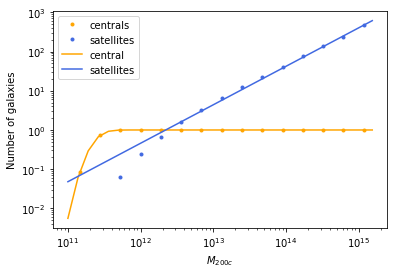

In [15]:
fig = plt.figure()
ax = plt.axes()
ax.plot((edges[1:]+edges[:-1])/2.,
           n_centrals_binned, #yerr = n_centrals_error, 
        color='orange', marker='o',markersize=3,
           label = 'centrals', linestyle='')

ax.plot((edges[1:]+edges[:-1])/2.,
           n_satellites_binned, #yerr = n_satellites_error, 
             color='royalblue', marker='o',markersize=3,
        label = 'satellites', linestyle='')

cen_model.param_dict = {'logMmin':popt_central[0], 'sigma_logM': popt_central[1]}

sats_model.param_dict = {'logM0': np.log10(popt_sats[0]), 
                'logM1': np.log10(popt_sats[1]), 'alpha': popt_sats[2]}
ax.plot(masses,
           cen_model.mean_occupation(prim_haloprop = masses), #yerr = n_satellites_error, 
             color='orange',
        label = 'central')

ax.plot(masses,
           sats_model.mean_occupation(prim_haloprop = masses) , #yerr = n_satellites_error, 
             color='royalblue',
        label = 'satellites')



ax.set_xscale("log")
ax.set_yscale("log")

ax.set_ylabel('Number of galaxies')
ax.set_xlabel(r'$M_{200c}$')
plt.legend()

# Performance on test set

In [16]:
np.random.seed(22222)

Udf = np.random.uniform(0,1,len(test_idx))

N_mean_cen = cen_model.mean_occupation(prim_haloprop = mass[test_idx])



In [17]:
Nc_test = (N_mean_cen > Udf).astype(int)

In [18]:
cm = confusion_matrix((labels[test_idx] > 0).astype(int), Nc_test)

Normalized confusion matrix


(array([[0.8622736 , 0.1377264 ],
        [0.16103585, 0.83896415]]),
 <matplotlib.axes._subplots.AxesSubplot at 0x2ad0e6502240>)

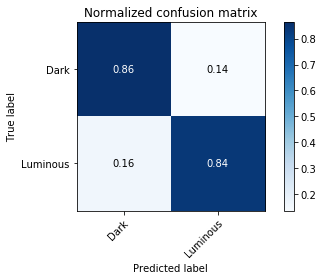

In [20]:
plot_confusion_matrix((labels[test_idx] > 0).astype(int),
    Nc_test, classes = ['Dark', 'Luminous'], 
    normalize = True)

## Populate halo catalog

In [22]:
from halotools.sim_manager import UserSuppliedHaloCatalog
from halotools.empirical_models import TrivialPhaseSpace, NFWPhaseSpace, HodModelFactory

In [23]:
mass.shape

(290605,)

In [24]:
len(np.arange(positions.shape[0]))

290605

In [33]:
halocat = UserSuppliedHaloCatalog( redshift = 0., Lbox = boxsize, 
        halo_x = positions[:, 0], halo_y = positions[:, 1], halo_z = positions[:, 2],
        halo_mvir = mass, halo_id = np.arange(mass.shape[0]),
        particle_mass = 1e9, halo_upid = -1. * np.ones_like(mass),
        halo_rvir = rvir
        )

In [26]:
cens_prof_model = TrivialPhaseSpace()

In [96]:
#sats_prof_model = TrivialPhaseSpace()

In [34]:
model_instance = HodModelFactory(
    centrals_occupation = cen_model,
    centrals_profile = cens_prof_model)

In [35]:
model_instance.populate_mock(halocat)


HalotoolsError: Your model requires that the ``halo_vx`` key appear in the halo catalog,
but this column is not available in the catalog you attempted to populate.
